# Testing Machine Unlearning against Gaussian data poisoning

This is a sample implementation of gaussian data poisoning as described by the AI Security paper [Machine Unlearning Fails to Remove Data Poisoning Attacks
](https://arxiv.org/abs/2406.17216).

## Imports

In [ ]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer, SGD, AdamW
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanSquaredError
import torchinfo

In [2]:
from image_classification.utils import seed_all_generators, use_tqdm
from image_classification.accel import BEST_DEVICE, optimize_model
from image_classification.datasets import EagerDataset
from image_classification.nn import (
    train_loop,
    test_epoch,
)
from image_classification.gaussian_poisoning import (
    GaussianPoisoningDataset,
    gaussian_unlearning_score,
)
from image_classification.unlearning import (
    gradient_descent,
    gradient_ascent,
    neg_grad_plus,
    unlearning_last_layers,
    scrub,
    NoisySGD,
)

# For deterministic results
seed_all_generators(0x2023_2024)

# NOTE: Don't forget to clear all outputs in vscode before running.
# 
# WARNING (Windows): consider setting ascii=True and installing vscode-tqdm
# if notebook display issues persist: https://pypi.org/project/vscode-tqdm/
# Alternatively, set enable=False (but there won't be interactive output).
use_tqdm(enable=True, ascii=False)

Using cuda device


## Datasets

Let's define the function to be learned here. For now, we start with a linear function.

In [3]:
# Dimensions of linear regression
# TODO: change the dimensions
n = 3
p = 7
# Input shape
in_shape = (p,)
# Output shape
out_shape = (n,)

# The true parameters of the function to be learned by the model.
weights = torch.rand(n, p, device=BEST_DEVICE)
bias = torch.rand(n, device=BEST_DEVICE)
print('W:', weights, '\n', 'b:', bias)

def centered_gaussians(size, std: float, seed=None):
    """
    Returns zero-centered noise.
    """
    g = torch.Generator(BEST_DEVICE)
    if seed is not None:
        g.manual_seed(seed)
    return torch.normal(mean=0, std=std, size=size, generator=g, device=BEST_DEVICE)

def f(x: Tensor, noise_scale=0.05) -> Tensor:
    """
    Returns an vector of length `n` from a vector of length `p`.
    
    This is the function to be learned.

    NOTE: this function can also be applied in batch by calling `f(X_batch)`
    where `X_batch` has a shape of the form `(N_batch, p)`. 
    """
    #assert x.shape[1:] == in_shape
    y = x @ weights.T + bias
    # Add internal variation to make this regression problem relevant for ML
    # NOTE: we need the noise to be a function of `x` and decorrelated to `x`.
    eps = centered_gaussians(y.shape, noise_scale * y.std(), seed=(hash(x) >> 33))
    return y + eps

W: tensor([[0.4111, 0.1111, 0.2623, 0.0312, 0.0831, 0.7803, 0.1876],
        [0.3155, 0.6756, 0.2323, 0.3382, 0.3678, 0.3181, 0.7212],
        [0.9766, 0.4785, 0.0953, 0.9867, 0.7639, 0.8005, 0.1607]],
       device='cuda:0') 
 b: tensor([0.8065, 0.8549, 0.5779], device='cuda:0')


### Generate the dataset

We start by generating the clean, non-poisoned features.

In [4]:

N = 10_000
batch_size = 64

# Generate random numbers since we don't want samples to be ordered
# since it would affect training
# TODO: see if data poisoning is affected by a specific initialization
X_base = torch.rand((N, *in_shape), device=BEST_DEVICE)
y_base = f(X_base)

print('Clean samples:', X_base.shape, y_base.shape)

Clean samples: torch.Size([10000, 7]) torch.Size([10000, 3])


### Linear regression sanity check

In [5]:
from sklearn import linear_model
from numpy.linalg import norm

X_a = X_base.numpy(force=True)
y_a = y_base.numpy(force=True)

regression_model = linear_model.LinearRegression(fit_intercept=True)
regression_model.fit(X_a, y_a)


err_hat = np.sqrt(1. - regression_model.score(X_a, y_a))
print(f'{err_hat=:.2g}')

W = weights.numpy(force=True)
b = bias.numpy(force=True)

W_hat = regression_model.coef_
b_hat = regression_model.intercept_

W_err = norm(W - W_hat, 2) / norm(W, 2)
b_err = norm(b - b_hat, 2) / norm(b, 2)
print(f'{W_err=:.2g}\t{b_err=:.2g}')

regression_model.coef_ = W
regression_model.intercept_ = b
err = np.sqrt(1. - regression_model.score(X_a, y_a))
print(f'{err=:.2g}')

err_hat=0.082
W_err=0.0018	b_err=0.00068
err=0.082


8 % of the output is noise.

### Create and split the daatset

In [6]:
data = EagerDataset(X_base, y_base)
training_data, test_data = data.split([8_000, 2_000])

### Poison the training samples

The attacker poisons a fraction $\varepsilon$ of the features with noise $(\xi_z)_{z \in S_\mathrm{poison}}$ and stores the noise for future usage.

In [7]:
# FIXME: for linear regression, we need very high values
# to observe the effect of data poisoning
poison_budget = 0.2
noise_std = 0.2 * X_base.std().item()

corrupted_dataset = GaussianPoisoningDataset(
    training_data,
    poison_budget,
    noise_std,
)

S_poison: Tensor[bool] = corrupted_dataset.poison_support
N_poison = corrupted_dataset.num_poisons()
N_clean = N - N_poison

X_base: Tensor = corrupted_dataset.clean_dataset.data[S_poison]
X_poison: Tensor = corrupted_dataset.data[S_poison]
poisoning_noise: Tensor = corrupted_dataset.noise[S_poison]

# Another independent standard noise used as a baseline for unlearning evaluation
# (not used to corrupt the dataset)
dummy_noise = noise_std * torch.randn_like(poisoning_noise)

print(f'Clean data standard deviation: {X_base.std().item():.2g}')
print(f'Noise standard deviation: {poisoning_noise.std().item():.2g}')
print('Noise data for poisoning:', poisoning_noise.shape)

Clean data standard deviation: 0.29
Noise standard deviation: 0.058
Noise data for poisoning: torch.Size([1656, 7])


Data poisoning creates a non-zero correlation between the poisoned data and the noise.

In [8]:
# Estimate correlation between the `kx` coordinate of the samples `X`
# and the `ky` coordinate of the samples `Y`.
def correlation(X: Tensor, Y: Tensor, kx=0, ky=0):
    #return torch.corrcoef(X[:, kx], Y[:, ky])
    return np.corrcoef(np.array(X[:, kx].cpu()), np.array(Y[:, ky].cpu()), rowvar=False)

print(
    'Correlation matrix of clean samples and poisons\n',
    correlation(X_base, poisoning_noise)
)
print(
    'Correlation matrix of poisoned samples and fresh gaussians\n',
    correlation(X_base, dummy_noise)
)
print(
    'Correlation matrix of poisoned samples and poisons\n',
    correlation(X_poison, poisoning_noise)
)
print(
    'Correlation matrix of fresh gaussians and poisons\n',
    correlation(dummy_noise, poisoning_noise)
)

Correlation matrix of clean samples and poisons
 [[1.         0.01555057]
 [0.01555057 1.        ]]
Correlation matrix of poisoned samples and fresh gaussians
 [[ 1.         -0.03792683]
 [-0.03792683  1.        ]]
Correlation matrix of poisoned samples and poisons
 [[1.         0.20833284]
 [0.20833284 1.        ]]
Correlation matrix of fresh gaussians and poisons
 [[ 1.         -0.00115203]
 [-0.00115203  1.        ]]


The defender unknowingly collects corrupted data, which contains a small fraction of poisons.

From now on, we consider the following scenario :
1. The defender trains the model on the corrupted dataset.
2. The defender realizes afterwards they have been poisoned, and is able to determine which part of the dataset has been corrupted.
3. The defender runs the unlearning algorithm on the poisoned dataset.

We may also study a stronger relaxation of step 2 with the hypothesis that the defender is able to determine the exact values of the poisons. This unrealistic scenario may be used to prove that Machine Unlearning is necessarily vulnerable to data poisoning. Indeed, if Machine Unlearning fails with such strong assumptions, we may conclude the effect of data poisoning on the model parameters is simply irreversible.

## The model architecture

We use a simple deep learning model with one hidden layer.

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: study the impact of parameters / dimension ratio
        # on the model's robustness to poisoning

        # A standard regression model would have `n * p` parameters.
        # This model has much more parameters, so it will most likely overfit.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(p, n * p),
            # FIXME: ReLU makes gradient vanish on one side, so we have to use
            # another type of activation function
            nn.LeakyReLU(),
            # Three layers might help the model overfit to the noise,
            # since it is highly irregular.
            # See this approximation theorem: https://arxiv.org/abs/2012.03016
            # NOTE: incidentally, with two layers we get opposite experiment results
            nn.Linear(n * p, n * p),
            nn.LeakyReLU(),
            nn.Linear(n * p, n),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
model = NeuralNetwork().to(BEST_DEVICE)

print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=21, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=21, out_features=21, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=21, out_features=3, bias=True)
  )
)


In [11]:
def inspect_model(model: nn.Module, title=''):
    print(f'===== Inspecting model {title} =====')
    print(torchinfo.summary(model))
    print('Inner state:\n', model.state_dict())
    print(f'(Note : real parameters are {weights}, {bias})\n')

## Train the model

### Clean sets, corrupted sets and poisons

In [12]:
# The retain set
clean_subset = corrupted_dataset.clean_subset()
clean_loader = DataLoader(clean_subset, batch_size)

# The forget set
poisoned_subset = corrupted_dataset.poisoned_subset()
poisoned_loader = DataLoader(poisoned_subset, batch_size)

# The forget set before poisoning
base_subset = corrupted_dataset.clean_subset_before_poisoning()
base_loader = DataLoader(base_subset, batch_size)

# The clean test set
test_loader = DataLoader(test_data, batch_size)

# The corrupted set (clean and poisons)
corrupted_loader = DataLoader(corrupted_dataset, batch_size)

### Hyperparameters

In [13]:
lr = 1e-1

epochs = 1

# We use MSE which is OK for linear regression purposes.
# We can also consider more robust losses such as F.l1_loss or F.huber_loss
loss_func = F.mse_loss

metric = MeanSquaredError(num_outputs=1).to(BEST_DEVICE)

In [14]:
def make_optimizer(model: nn.Module, lr=1e-2, weight_decay=0.0) -> Optimizer:
    return AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

### Clean model

In [15]:
clean_model = deepcopy(model)
opt = make_optimizer(clean_model)
train_loop(clean_model, clean_loader, loss_func, opt, epochs=epochs)
test_epoch(clean_model, test_loader, loss_func, keep_pbars=True, metric=metric)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Train loop: 100%|██████████| 6344/6344 [00:00<00:00, 6577.99it/s, loss=0.0179]


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 12770.91it/s, MeanSquaredError=0.0202, avg_loss=0.0176]


### Corrupted model

In [16]:
corrupted_model = deepcopy(model)
opt = make_optimizer(corrupted_model)
train_loop(corrupted_model, corrupted_loader, loss_func, opt, epochs=1)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 8000/8000 [00:00<00:00, 11691.49it/s, loss=0.013]


In [ ]:
#inspect_model(corrupted_model)

# FIXME: loss shouldn't be strictly equal to zero
print('\n\nOn the clean subset:')
test_epoch(corrupted_model, clean_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the (clean) test set:')
test_epoch(corrupted_model, test_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the original version of the poisoned subset before poisoning:')
test_epoch(corrupted_model, base_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the poisoned subset:')
test_epoch(corrupted_model, poisoned_loader, loss_func, keep_pbars=True, metric=metric)




On the clean subsevt:


Test loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Test loop: 100%|██████████| 6344/6344 [00:00<00:00, 10440.99it/s, MeanSquaredError=0.0106, avg_loss=0.0117]


On the (clean) test set:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 15941.07it/s, MeanSquaredError=0.0163, avg_loss=0.0125]


On the original version of the poisoned subset before poisoning:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 8187.39it/s, MeanSquaredError=0.0126, avg_loss=0.0115]


On the poisoned subset:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 9357.73it/s, MeanSquaredError=0.0184, avg_loss=0.0163]


The loss values are extremely small since the function to be learned is a simple linear function and the model is excessively large. It is quite remarkable that the model actually performs better on the clean dataset than the corrupted dataset, even though it was trained on the corrupted one. This means the model did not really learn the noise (did not overfit).

### Are model outputs correlated to the noise?

In [18]:
with torch.no_grad():
    print(
        'Correlation matrix of model outputs (before unlearning) and fresh noise\n',
        correlation(corrupted_model(X_poison), dummy_noise)
    )
    print(
        'Correlation matrix of model outputs (before unlearning) and poisoning noise\n',
        correlation(corrupted_model(X_poison), poisoning_noise)
    )

Correlation matrix of model outputs (before unlearning) and fresh noise
 [[ 1.         -0.02292912]
 [-0.02292912  1.        ]]
Correlation matrix of model outputs (before unlearning) and poisoning noise
 [[1.         0.09091505]
 [0.09091505 1.        ]]


**Indeed!**

### Model shift with poisoning

TODO: prove that model update direction is orthogonal

In [19]:
def model_to_tensor(model: nn.Module) -> Tensor:
    params = [
        param.detach().flatten()
        for param in model.parameters()
    ]
    return torch.cat(params)

def model_gradients(model: nn.Module) -> Tensor:
    params = [
        param.grad.detach().flatten()
        for param in model.parameters()
    ]
    return torch.cat(params)
        

In [20]:
def make_corrupted_dataset(
        poison_budget: float,
        eps: float = 0.2,
    ) -> GaussianPoisoningDataset:
    noise_std = eps * training_data.data.std().item()
    return GaussianPoisoningDataset(
        training_data,
        poison_budget,
        noise_std,
    )

def train_new_model_on(
        dataset: Dataset,
    ) -> NeuralNetwork:
    corrupted_loader = DataLoader(dataset, batch_size)

    poisoned_model = NeuralNetwork().to(BEST_DEVICE)
    opt = make_optimizer(poisoned_model, lr=5e-3)
    train_loop(poisoned_model, corrupted_loader, loss_func, opt, epochs=epochs, keep_pbars=False)

    return poisoned_model

In [21]:
def model_relative_diff(
        clean_model: nn.Module,
        poisoned_model: nn.Module,
    ) -> float:
    clean_model.eval()
    poisoned_model.eval()

    theta_corr = model_to_tensor(poisoned_model)
    theta_clean = model_to_tensor(clean_model)
    diff = torch.norm(theta_corr - theta_clean, 1)
    return (diff / torch.norm(theta_clean, 1)).item()

In [41]:
model_relative_diff(clean_model, corrupted_model)

0.06450104713439941

In [78]:
def model_shift_against_poison_budget(n=30):
    poison_budgets = np.linspace(0.0, 1.0, n)
    rows = []
    for poison_budget in poison_budgets:
        corrupted_data = make_corrupted_dataset(poison_budget)
        poisoned_model = train_new_model_on(corrupted_data)
        model_shift = model_relative_diff(clean_model, poisoned_model)
        rows.append([poison_budget, model_shift])
    
    return pd.DataFrame(rows, columns=['poison_budget', 'model_shift'])


In [79]:
df = model_shift_against_poison_budget()

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/8000 [00:00<?, ?it/s]

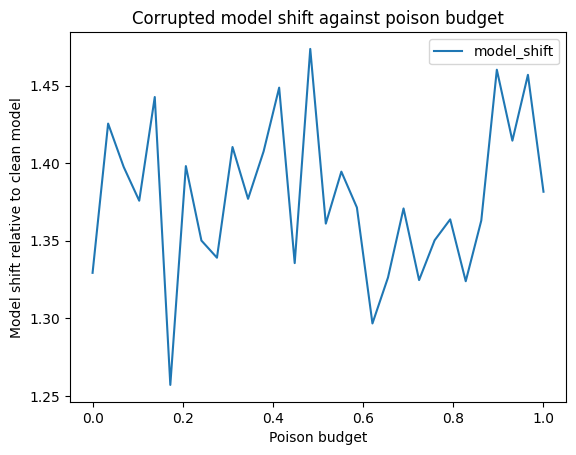

In [80]:
df.plot.line(x='poison_budget', y='model_shift')
plt.xlabel('Poison budget')
plt.ylabel('Model shift relative to clean model')
plt.title('Corrupted model shift against poison budget')
plt.show()

FIXME: this is not coherent with the order of magnitude of the previous value!

In [58]:
def figure_5_a(
        clean_model: nn.Module,
        poisoned_model: nn.Module,
        clean_loader: DataLoader,
        loss_fn: _Loss,
    ):
    clean_model.eval()
    poisoned_model.eval()

    cos_sims = []

    theta_clean = model_to_tensor(clean_model)

    #def grad_hook(model: nn.Module, grad_input):
    #    theta = model_to_tensor(model)
    #    g = model_gradients(model)
    #    v = theta - theta_clean
    #    cos_sims.append(torch.cosine_similarity(v, g, dim=0).item())

    #handle = poisoned_model.register_full_backward_pre_hook(grad_hook)

    for X_b, y_b in clean_loader:
        loss = loss_fn(poisoned_model(X_b), y_b)
        loss.backward()

        g = model_gradients(poisoned_model)
        v = model_to_tensor(poisoned_model) - theta_clean
        cos_sims.append(torch.cosine_similarity(v, g, dim=0).item())
    
    cos_sims = np.array(cos_sims)

    #handle.remove()

    plt.hist(cos_sims, bins='rice')
    plt.xlabel(fr'$\langle v, g_t \rangle / \Vert v \Vert \Vert g_t \Vert$')
    
    axes = plt.gca()
    axes.xaxis.set_major_formatter('{x:.1e}')

    plt.title(fr'Cosine similarity between batch gradient updates and clean vs. poison model shift')
    plt.show()


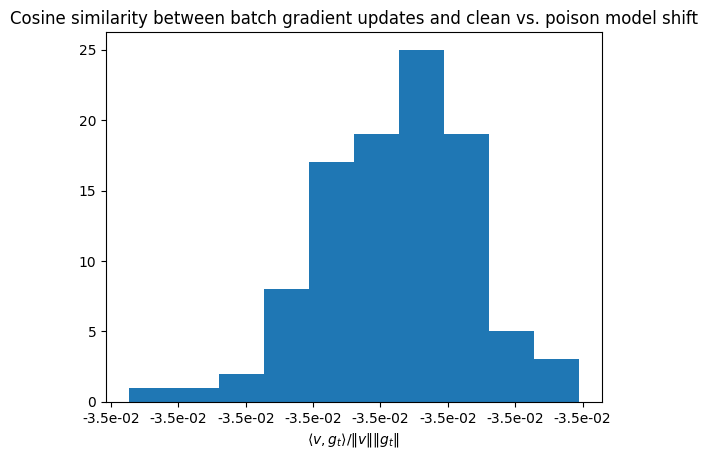

In [59]:
figure_5_a(clean_model, corrupted_model, clean_loader, loss_func)

Interpretation: after poisoning, the model shift is orthogonal to the batch gradient updates, which means gradient-based methods fail to effectively unlearn the noise.

TODO: give a mathematical explanation for simple models

## Machine Unlearning

### Gradient Descent (GD)

> GD continues to train the model $\theta_{\mathrm{initial}}$ on the
remaining dataset $S_{\mathrm{train}} \setminus U$ by using gradient descent. In particular, we obtain $\theta_{\mathrm{updated}}$ via
> 
> $\theta_{t+1} \gets \theta_t − \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $\eta$ denotes the step size and $g_t$ denotes a (mini-batch) gradient computed for the the training
loss $\widehat{\mathbb{E}}_{(x,y) \in S_{\mathrm{train}} \setminus U} \left[l((x, y), \theta)\right]$ defined using the remaining dataset $S_{\mathrm{train}} \setminus U$, where $l$ is a loss function, e.g., cross-entropy loss, hinge loss, etc.

### Gradient Ascent (GA)

> GA is an unlearning algorithm which attempts to remove the influence of the forget set $U$ from the trained model by simply reversing the gradient updates that contain information about $U$. In particular, we update via
> 
> $\theta_{t+1} \gets \theta_t + \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $g_t$ denotes a (mini-batch) gradient computed for the the training loss $\widehat{\mathbb{E}}_{(x,y) \in U} \left[l((x, y), \theta)\right]$ on the deletion
set.

## Evaluate the effect of Gaussian data poisoning

We follow the *Algorithm 3* in the original paper of Pawelczyk et al.

In [27]:
# NOTE: the computed standard deviation might not be 1 due to gradient vanishing
def evaluate_unlearning(
        model: nn.Module,
        base_data: Dataset,
        noise: Dataset,
        noise_std: float,
        loss_fn: _Loss,
        xi_name=r'$\xi$', g_name='g', method='',
    ):
    I_poison = gaussian_unlearning_score(
        model,
        base_data,
        noise,
        noise_std,
        loss_fn,
    )

    mean = I_poison.mean()
    std = I_poison.std()

    mean_std_theory = 1. / np.sqrt(float(len(noise)))

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std**2:.3})$')
    
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0 \pm {mean_std_theory:.3g}, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    if method:
        plt.suptitle(method)
    plt.legend()
    plt.show()

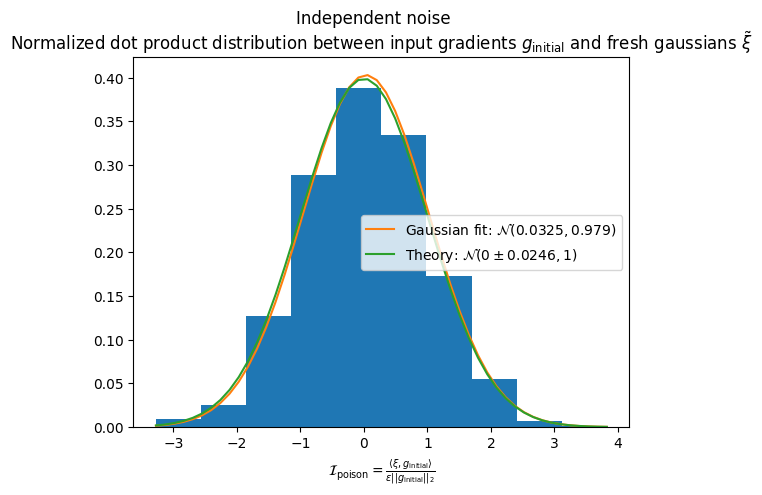

In [28]:
evaluate_unlearning(
    corrupted_model, base_subset, dummy_noise, noise_std, loss_func,
    xi_name=r'fresh gaussians $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}', method='Independent noise'
)

When testing against independent noise, the result should be equivalent to perfect unlearning.

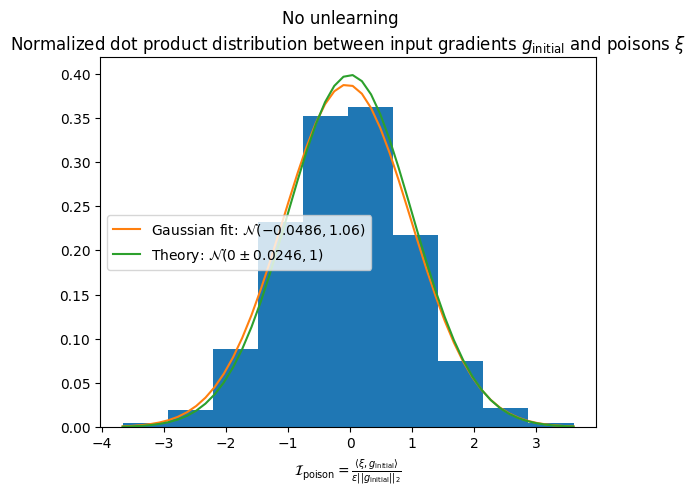

In [29]:
evaluate_unlearning(
    corrupted_model, base_subset, poisoning_noise, noise_std, loss_func,
    xi_name=r'poisons $\xi$', g_name=r'g_{\mathrm{initial}}', method='No unlearning'
)

For fresh Gaussians, the distribution should be centered around $0$.

Due to data poisoning, the model gradients are influenced by $\xi$ so the distribution is shifted.

FIXME: actually, there is very little correlation because the model seems to have minimized the loss over the clean samples rather than the poisoned samples, which is why the loss gradient is not correlated with the noise.

### Evaluate unlearning algorithms

We plot the previous distribution again, after running the unlearning algorithm.
If the distribution is still shifted, that means the model did not perfectly unlearn the poisons.

In [30]:
def display_post_unlearning_results(model: nn.Module, algo_name: str):
    print('\n\nTest on clean samples:')
    test_epoch(model, test_loader, loss_func, keep_pbars=True, metric=metric)
    print('\n\nTest on poisoned samples:')
    test_epoch(model, poisoned_loader, loss_func, keep_pbars=True, metric=metric)
    print('\n\n')
    evaluate_unlearning(
        model, base_subset, poisoning_noise, noise_std, loss_func,
        xi_name=r'Gaussian poisons $\xi$',
        g_name=r'g_{\mathrm{updated}}',
        method=algo_name,
    )

### Gradient descent

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Train loop: 100%|██████████| 6344/6344 [00:01<00:00, 6064.01it/s, loss=0.00149]


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 16655.10it/s, avg_loss=0.00164]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 13787.12it/s, MeanSquaredError=0.00142, avg_loss=0.00164]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 8008.25it/s, MeanSquaredError=0.00859, avg_loss=0.00789]





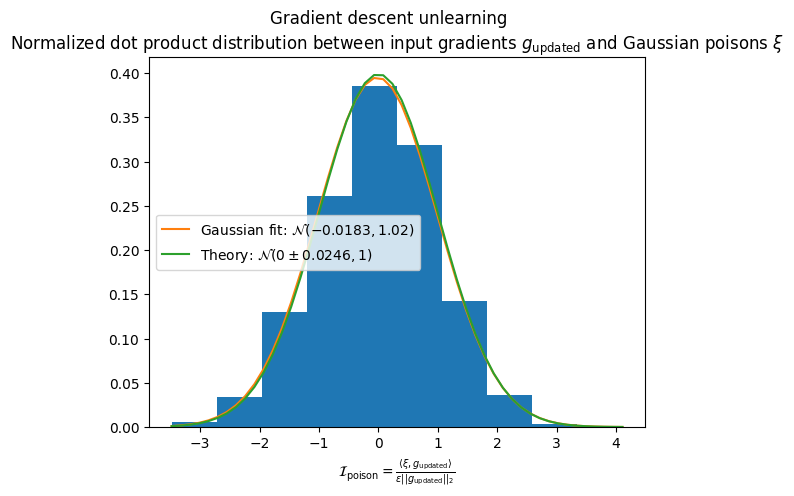

In [31]:
unlearner = deepcopy(corrupted_model)
opt_gd = make_optimizer(unlearner, lr=0.5 * lr)
gradient_descent(unlearner, clean_loader, test_loader, loss_func, opt_gd, epochs=1)
display_post_unlearning_results(unlearner, algo_name='Gradient descent unlearning')

### Noisy gradient descent

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Train loop: 100%|██████████| 6344/6344 [00:00<00:00, 7722.92it/s, loss=0.0106]


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 15139.60it/s, avg_loss=0.0125]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 14530.76it/s, MeanSquaredError=0.0163, avg_loss=0.0125]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 9259.23it/s, MeanSquaredError=0.0184, avg_loss=0.0163]





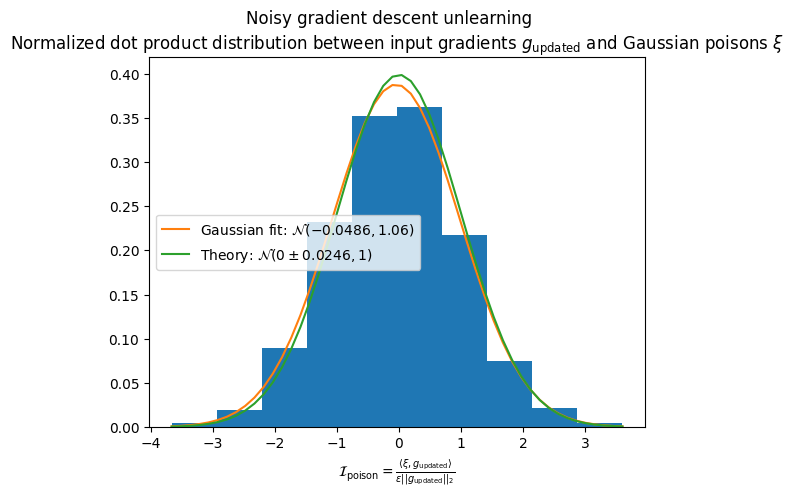

In [38]:
unlearner = deepcopy(corrupted_model)
opt_ngd = NoisySGD(unlearner.parameters(), noise_scale=np.sqrt(1e-6), lr=1e-1)
gradient_descent(unlearner, clean_loader, test_loader, loss_func, opt_gd, epochs=1)
display_post_unlearning_results(unlearner, algo_name='Noisy gradient descent unlearning')

### Gradient ascent

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Train loop: 100%|██████████| 6344/6344 [00:00<00:00, 7084.41it/s, loss=-1.6e+7]


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 19149.97it/s, avg_loss=-1.54e+7]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 12471.99it/s, MeanSquaredError=1.7e+7, avg_loss=1.54e+7]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 6993.56it/s, MeanSquaredError=1.61e+7, avg_loss=1.55e+7]





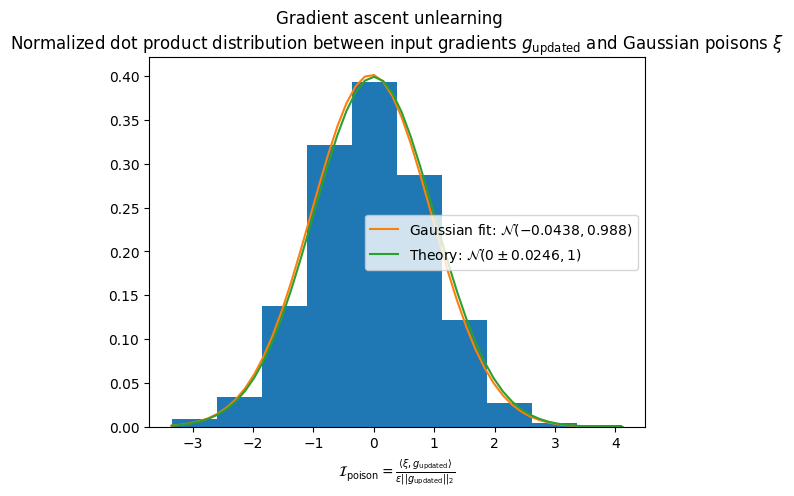

In [33]:
unlearner = deepcopy(corrupted_model)
opt_ga = make_optimizer(unlearner, lr=0.1 * lr)
gradient_ascent(unlearner, clean_loader, test_loader, loss_func, opt_ga, epochs=epochs)
display_post_unlearning_results(unlearner, algo_name='Gradient ascent unlearning')

Gradient ascent completely fails to maintain a good overall performance. Seems like the algorithm is overfitting on unlearning.

### NegGrad+

NegGrad+:   0%|          | 0/8000 [00:00<?, ?it/s]

NegGrad+: 11592it [00:11, 1041.25it/s, loss=0.00327, loss_forget=0.0241, loss_retain=0.00329]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 12336.01it/s, MeanSquaredError=0.00677, avg_loss=0.00688]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 8990.13it/s, MeanSquaredError=0.0139, avg_loss=0.013]





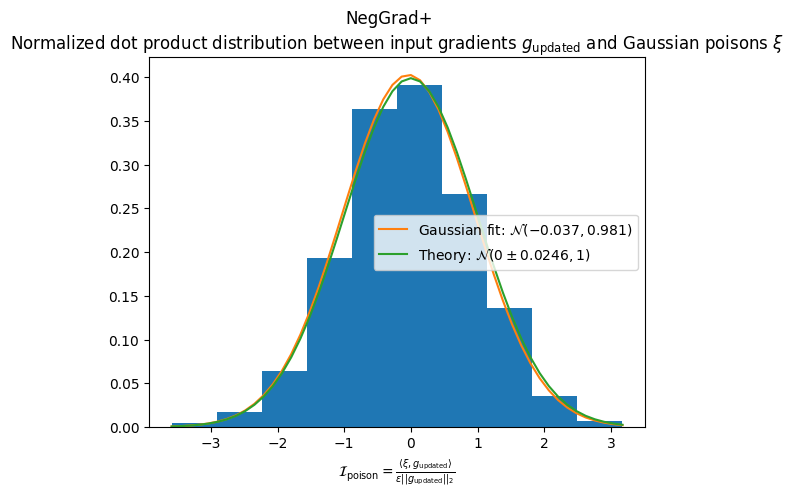

In [34]:
unlearner = deepcopy(corrupted_model)
opt_ngp = make_optimizer(unlearner, lr=0.3 * lr)
neg_grad_plus(unlearner, clean_subset, poisoned_subset, loss_func, opt_ngp)
display_post_unlearning_results(unlearner, algo_name='NegGrad+')

### CFk

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Train loop: 100%|██████████| 6344/6344 [00:00<00:00, 11021.25it/s, loss=0.00149]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 23308.10it/s, MeanSquaredError=0.00142, avg_loss=0.00164]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 13296.80it/s, MeanSquaredError=0.00859, avg_loss=0.00789]





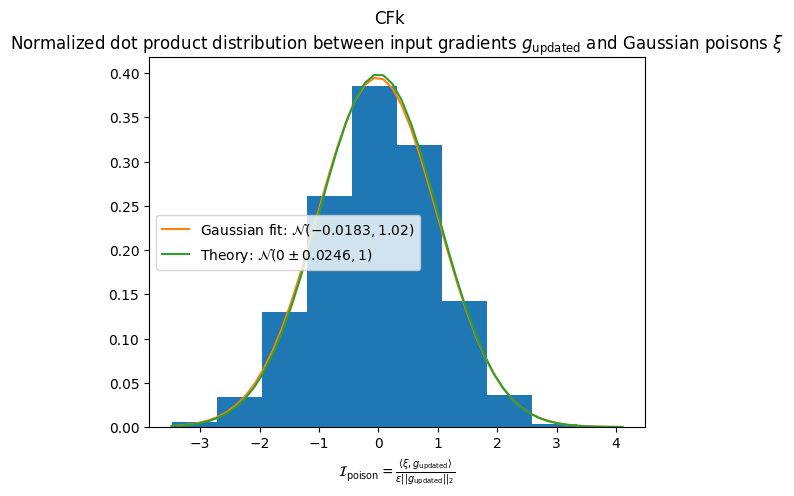

In [60]:
unlearner = deepcopy(corrupted_model)
with unlearning_last_layers(unlearner, 1, mode='cfk'):
    opt_cfk = make_optimizer(unlearner, lr=0.5 * lr)
    train_loop(unlearner, clean_loader, loss_func, opt_cfk, epochs=1)
display_post_unlearning_results(unlearner, algo_name='CFk')

### EUk

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/6344 [00:00<?, ?it/s]

Train loop: 100%|██████████| 6344/6344 [00:00<00:00, 10752.09it/s, loss=0.00149]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 29132.27it/s, MeanSquaredError=0.00142, avg_loss=0.00164]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 12377.21it/s, MeanSquaredError=0.00859, avg_loss=0.00789]





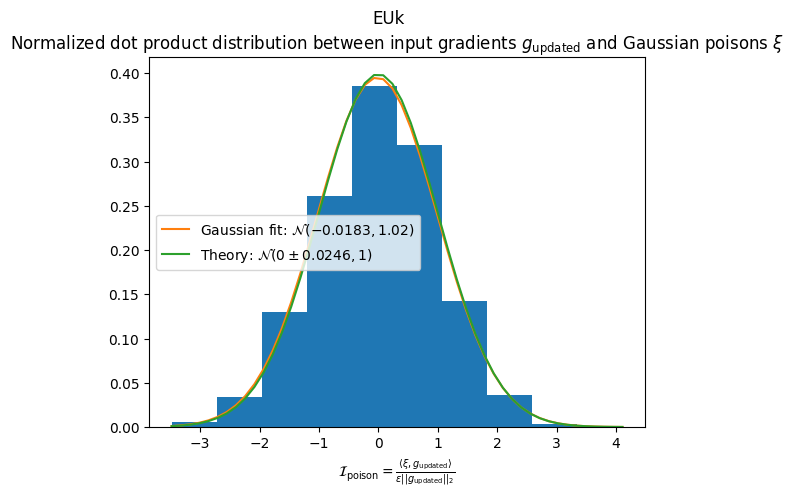

In [63]:
unlearner = deepcopy(corrupted_model)
with unlearning_last_layers(unlearner, 1, mode='euk'):
    opt_euk = make_optimizer(unlearner, lr=0.5 * lr)
    train_loop(unlearner, clean_loader, loss_func, opt_euk, epochs=epochs)
display_post_unlearning_results(unlearner, algo_name='EUk')

### SCRUB

SCRUB epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Transfer learning epoch:   0%|          | 0/8000 [00:00<?, ?it/s]

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.12/site-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Transfer learning epoch: 11592it [00:05, 1945.22it/s, loss=0]


Transfer learning epoch:   0%|          | 0/8000 [00:00<?, ?it/s]

Transfer learning epoch: 44408it [00:23, 1904.07it/s, loss=0.000886]


Test on clean samples:


Test loop:   0%|          | 0/2000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 2000/2000 [00:00<00:00, 19196.87it/s, MeanSquaredError=2.03, avg_loss=1.88]


Test on poisoned samples:


Test loop:   0%|          | 0/1656 [00:00<?, ?it/s]

Test loop: 100%|██████████| 1656/1656 [00:00<00:00, 13069.17it/s, MeanSquaredError=1.96, avg_loss=1.89]





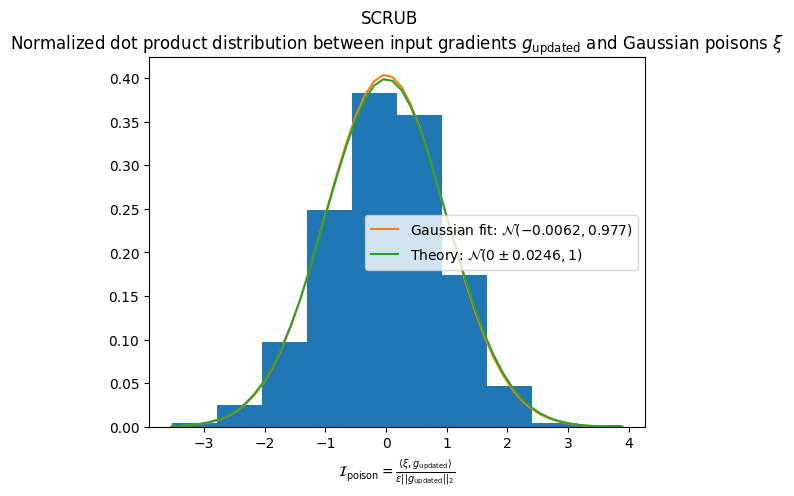

In [62]:
teacher = deepcopy(corrupted_model)
student = deepcopy(teacher)
opt_scrub = make_optimizer(unlearner, lr=lr)
scrub(
    teacher, student,
    clean_subset, poisoned_subset,
    loss_func, opt_scrub,
    max_steps=epochs, steps=epochs,
)
display_post_unlearning_results(unlearner, algo_name='SCRUB')

## Takeaways

Disclaimer: the experiment results do not provide strong evidence.

Ablation study :

- Larger models are more vulnerable to data poisoning. Indeed, when the model dimension is very high compared to the feature dimension, the model is likely to overfit on the poisons, therefore making them hard to forget.
- Data poisoning has a larger effect on high-dimensioned data. We should adapt our experiment to images to see the difference.
- For simple problems such as linear regression, the effect of data poisoning seems to decrease as the number of samples grows. To get an intuition of why this is true, consider the $1$-dimensional linear regression: the estimated slope coefficient converges to the true slope coefficient, even if the training data is poisoned.
- Techniques such as gradient ascent unlearning (GA) are more efficient at removing poisons, however the model becomes widly inaccurate on the base dataset. This highlights the tradeoff between privacy and usefulness. For unlearning, we need to make a compromise between GD and GA.